In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install tensorflow_text

     |████████████████████████████████| 4.4 MB 925 kB/s 
     |████████████████████████████████| 458.3 MB 9.5 kB/s 
     |████████████████████████████████| 3.9 MB 30.5 MB/s 
     |████████████████████████████████| 1.3 MB 33.6 MB/s 
     |████████████████████████████████| 4.0 MB 38.5 MB/s 
     |████████████████████████████████| 462 kB 51.7 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=35f40062aa27ff996a70a7f7757eb19c7f1fe271b7dd17ab6385e100a2b4d05e
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
Successfully built clang
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attemptin

In [3]:
#Importing dependencies

import pandas as pd
import numpy as np
import os
import re
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from sklearn.pipeline import make_pipeline as pipe
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as LemmaT

from xgboost.sklearn import XGBClassifier as XGB
from sklearn.ensemble import RandomForestClassifier as RF, AdaBoostClassifier as ADA, VotingClassifier as Vote, StackingClassifier as Stack
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from transformers import pipeline

import tensorflow as tf
from tensorflow.keras import Sequential,layers
%matplotlib inline
import fasttext
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_text as text
from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, BertTokenizer

In [4]:
max_features=2000
max_len=512

In [5]:
#read training data

train_data=pd.read_csv("../input/intermediate-nlp-mlbuzz/processed_data.csv")

train_data.head()

,File_name,Industry,Sub-category,Article
0,32577.txt,Power Industry,Green Energy,natural gas produce around half emission coal ...
1,12871.txt,Health Industry,Diagnostic,sanctuary santa maria della steccata in bc cit...
2,10812.txt,Health Industry,Pharma,in pure bismarck system access insurance seen ...
3,21494.txt,Manufacturing Industry,Production,voting right volkswagen integrating scania man...
4,3744.txt,Automobile Industry,Heavy Vehicles,lb required upper stage payload perform final ...


In [6]:
# all the industry can be directly predicted if sub categories is known
ind_cat={}
cat_ind={}
for i in range(len(train_data)):
    ind=train_data["Industry"].iloc[i]
    cat=train_data["Sub-category"].iloc[i]
    if ind in ind_cat:
        if cat not in ind_cat[ind]:
            ind_cat[ind].append(cat)
    else:
        ind_cat[ind]=[cat]
        
    if cat not in cat_ind:
        cat_ind[cat]=ind
        
print(ind_cat,cat_ind)

{'Power Industry': ['Green Energy', 'Non-green Energy'], 'Health Industry': ['Diagnostic', 'Pharma'], 'Manufacturing Industry': ['Production', 'Toys', 'Food', 'Mechanical'], 'Automobile Industry': ['Heavy Vehicles', 'Light Vehicles'], 'Computer Industry': ['Hardware', 'Software', 'Security']} {'Green Energy': 'Power Industry', 'Diagnostic': 'Health Industry', 'Pharma': 'Health Industry', 'Production': 'Manufacturing Industry', 'Heavy Vehicles': 'Automobile Industry', 'Light Vehicles': 'Automobile Industry', 'Non-green Energy': 'Power Industry', 'Hardware': 'Computer Industry', 'Toys': 'Manufacturing Industry', 'Food': 'Manufacturing Industry', 'Mechanical': 'Manufacturing Industry', 'Software': 'Computer Industry', 'Security': 'Computer Industry'}


In [7]:
x=train_data["Article"]
y=train_data["Sub-category"]

enc1hot = OneHotEncoder(handle_unknown='ignore')
enc_ord = OrdinalEncoder()

y1hot=enc1hot.fit_transform(y.to_numpy().reshape(-1,1)).toarray()
y_ord=enc_ord.fit_transform(y.to_numpy().reshape(-1,1))

In [8]:
cnt_vec=CountVectorizer(ngram_range=(1,3),max_features=200)
x_vec=cnt_vec.fit_transform(x)

In [9]:
type(x_vec)

scipy.sparse.csr.csr_matrix

In [10]:
# pca=PCA().fit(x_vec.toarray())
# plt.plot(pca2.explained_variance_, linewidth=2)

In [11]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# xtokens = tokenizer.batch_encode_plus(list(x),add_special_tokens=True,truncation=True,padding="max_length",max_length=max_len,return_attention_mask=False,return_tensors='np')
# xtokens

In [12]:
# x_enc=xtokens['input_ids']
# # x_enc=x_enc.reshape((-1,x.shape[1],1))
# x_enc.shape

In [13]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# # bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# bert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=13)

In [14]:
# #tokenization

# xtokens = tokenizer.batch_encode_plus(list(x),add_special_tokens=True,truncation=True,padding="max_length",max_length=100,return_attention_mask=True,return_tensors='tf')
# xtokens

In [15]:
# BATCH_SIZE = 64  # we will use batches of 32

# dataset = tf.data.Dataset.from_tensor_slices((xtokens.input_ids, xtokens.attention_mask, y1hot))

# def map_func(input_ids, masks, labels):
#     return {'input_ids': input_ids, 'attention_mask': masks}, labels

# # using map method to apply map_func to dataset
# dataset = dataset.map(map_func)

# # shuffle data and batch it
# dataset = dataset.shuffle(100000).batch(BATCH_SIZE)

# # get the length of the batched dataset
# DS_LEN = len([0 for batch in dataset])
# SPLIT = 0.9  # 90-10 split

# train = dataset.take(round(DS_LEN*SPLIT))  # get first 90% of batches
# val = dataset.skip(round(DS_LEN*SPLIT))  # skip first 90% and keep final 10%

# del dataset  # optionally, delete dataset to free up disk-space

In [16]:
# # #test train split

# xtrain,xtest,ytrain,ytest=train_test_split(x,y1hot,test_size=0.3,random_state=7)
# print(len(xtrain),len(xtest),len(ytrain),len(ytest))

In [17]:
# ##Model

# def model():
#     input_ids = tf.keras.layers.Input(shape=(), name='input_ids', dtype='int32')
#     mask = tf.keras.layers.Input(shape=(), name='attention_mask', dtype='int32')
# #     x=tokenizer.encode_plus(x,add_special_tokens=True,truncation=True,padding="max_length",max_length=512,return_attention_mask=True,return_tensors='tf')
#     x=bert_model(input_ids, attention_mask=mask)
#     x=tf.keras.layers.BatchNormalization()(x.pooler_output)
#     x=tf.keras.layers.Dropout(0.25)(x)
#     x=tf.keras.layers.Dense(13, activation='softmax')(x)

    

# deepNN=model()

In [18]:
# #model

# input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
# mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# # we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
# X = bert_model(input_ids, attention_mask=mask)

# # X = tf.keras.layers.LSTM(64)(X)
# X = tf.keras.layers.BatchNormalization()(X.pooler_output)
# X = tf.keras.layers.Dense(64, activation='relu')(X)
# X = tf.keras.layers.Dropout(0.2)(X)
# y = tf.keras.layers.Dense(13, activation='softmax', name='outputs')(X)

# # define input and output layers of our model
# model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# # freeze the BERT layer - otherwise we will be training 100M+ parameters...
# model.layers[2].trainable = False


# optimizer = tf.keras.optimizers.Adam(0.01)
# loss = tf.keras.losses.CategoricalCrossentropy()  # categorical = one-hot
# acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

# model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
# callback=tf.keras.callbacks.EarlyStopping(monitor="val_acc",min_delta=0.01,patience=5,restore_best_weights=True)
# history = model.fit(train,validation_data=val,batch_size=32,callbacks=[callback],epochs=20,shuffle=True)

In [19]:
# optimizer = tf.keras.optimizers.Adam(0.01)
# loss = tf.keras.losses.CategoricalCrossentropy()  # categorical = one-hot
# acc = tf.keras.metrics.CategoricalAccuracy('accuracy')


# bert_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
# callback=tf.keras.callbacks.EarlyStopping(monitor="val_acc",min_delta=0.01,patience=5,restore_best_weights=True)
# history = bert_model.fit(train,validation_data=val,batch_size=64,callbacks=[callback],epochs=20,shuffle=True)

In [20]:
# lstm


def LSTM_model():
    model=Sequential()
    model.add(layers.Embedding(200,256))
#     model.add(LSTM(256,activation='tanh',recurrent_activation='sigmoid',dropout=0.25,recurrent_dropout=0.25,return_sequences=True,input_shape=(None,1)))
#     model.add(layers.Bidirectional(layers.LSTM(64,activation='tanh',recurrent_activation='sigmoid',dropout=0.25,recurrent_dropout=0.25)))
    model.add(layers.LSTM(64,activation='tanh',recurrent_activation='sigmoid',dropout=0.25,recurrent_dropout=0.25))
#     model.add(layers.Dense(64,activation='tanh'))
#     model.add(layers.Dropout(0.25))
#     model.add(layers.BatchNormalization())
    model.add(layers.Dense(13,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [21]:
model=LSTM_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         51200     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                82176     
_________________________________________________________________
dense (Dense)                (None, 13)                845       
Total params: 134,221
Trainable params: 134,221
Non-trainable params: 0
_________________________________________________________________


2021-10-22 04:02:10.763834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 04:02:10.811959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib64:/usr/local/cuda/lib64:/opt/conda/lib
2021-10-22 04:02:10.823099: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-10-22 04:02:10.824248: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [22]:
callback=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=30,restore_best_weights=True)
history = model.fit(x_vec.toarray(),y1hot,batch_size=64,callbacks=[callback],epochs=300,shuffle=True,validation_split=0.2)

2021-10-22 04:02:11.665826: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300
398/398 [==============================] - 241s 600ms/step - loss: 2.4210 - accuracy: 0.1654 - val_loss: 2.3300 - val_accuracy: 0.1910
Epoch 2/300
398/398 [==============================] - 234s 589ms/step - loss: 2.2309 - accuracy: 0.2330 - val_loss: 2.1349 - val_accuracy: 0.2705
Epoch 3/300
398/398 [==============================] - 231s 581ms/step - loss: 2.0465 - accuracy: 0.2862 - val_loss: 1.9596 - val_accuracy: 0.3125
Epoch 4/300
398/398 [==============================] - 231s 581ms/step - loss: 1.9448 - accuracy: 0.3169 - val_loss: 1.8486 - val_accuracy: 0.3513
Epoch 5/300
398/398 [==============================] - 233s 586ms/step - loss: 1.8722 - accuracy: 0.3386 - val_loss: 1.8214 - val_accuracy: 0.3559
Epoch 6/300
398/398 [==============================] - 238s 597ms/step - loss: 1.8062 - accuracy: 0.3522 - val_loss: 1.7219 - val_accuracy: 0.3840
Epoch 7/300
398/398 [==============================] - 238s 598ms/step - loss: 1.7449 - accuracy: 0.3688 - val_loss: 1

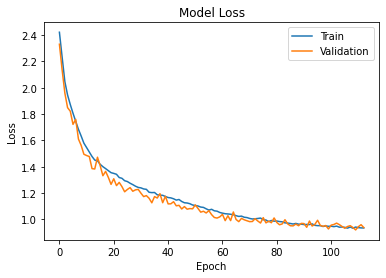

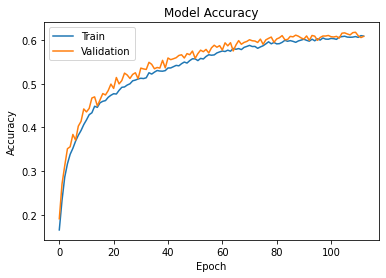

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()